# Proyecto A: Optimización en la Planeación de Transporte Vehicular Urbana Para LogistiCo

## Integrantes

- Barrera Toro, Javier Steven
- Rolon Toloza, Julian Santiago
- Borbon Holguin, Luis Alfredo

# Implementación del modelo matemático y procesamiento de datos

In [1]:
import pandas as pd
from pyomo.environ import *
from pyomo.opt import SolverFactory

## Procesamiento de datos

In [2]:
%pip install geopy
import pandas as pd
import os
from geopy.distance import geodesic

ruta_clientes_csv = r'D:\Biblioteca\Escritorio\ok\clients.csv'
ruta_depositos_csv = r'D:\Biblioteca\Escritorio\ok\depots.csv'
df_vehiculos = pd.read_csv(r'D:\Biblioteca\Escritorio\ok\vehicles.csv')

directorio_salida_consolidado = 'Proyecto_Caso_Base'
nombre_archivo_ubicaciones_consolidadas = 'locations.csv'
ruta_ubicaciones_consolidadas_csv = os.path.join(directorio_salida_consolidado, nombre_archivo_ubicaciones_consolidadas)

if not os.path.exists(directorio_salida_consolidado):
    os.makedirs(directorio_salida_consolidado)
    print(f"Directorio '{directorio_salida_consolidado}' creado.")

try:
    print(f"Cargando datos de clientes desde: {ruta_clientes_csv}")
    df_clientes = pd.read_csv(ruta_clientes_csv)

    print(f"Cargando datos de depósitos desde: {ruta_depositos_csv}")
    df_depositos = pd.read_csv(ruta_depositos_csv)

except FileNotFoundError as e:
    print(f"Error: No se pudo encontrar el archivo {e.filename}. Asegúrate de que las rutas sean correctas.")
    exit()

df_depositos_ubic = df_depositos[['LocationID', 'Longitude', 'Latitude']].copy()
df_clientes_ubic = df_clientes[['LocationID', 'Longitude', 'Latitude']].copy()

ubicaciones_consolidadas_df = pd.concat([
    df_depositos_ubic,
    df_clientes_ubic
], ignore_index=True)

try:
    ubicaciones_consolidadas_df.to_csv(ruta_ubicaciones_consolidadas_csv, index=False)
    print(f"Archivo de ubicaciones consolidadas guardado en: {ruta_ubicaciones_consolidadas_csv}")
except Exception as e:
    print(f"Error al guardar el archivo de ubicaciones consolidadas: {e}")
    exit()

try:
    print(f"Cargando ubicaciones consolidadas desde: {ruta_ubicaciones_consolidadas_csv}")
    df_ubicaciones_para_matriz = pd.read_csv(ruta_ubicaciones_consolidadas_csv)
except FileNotFoundError:
    print(f"Error: El archivo consolidado '{ruta_ubicaciones_consolidadas_csv}' no fue encontrado.")
    exit()

print("Calculando matriz de distancias...")
lista_ids_ubicaciones = df_ubicaciones_para_matriz['LocationID'].tolist()
n_ubicaciones = len(lista_ids_ubicaciones)
matriz_distancias_lista = [[0.0] * n_ubicaciones for _ in range(n_ubicaciones)]

for i in range(n_ubicaciones):
    fila_origen = df_ubicaciones_para_matriz.iloc[i]
    coord_origen = (fila_origen['Latitude'], fila_origen['Longitude'])
    for j in range(n_ubicaciones):
        if i == j:
            matriz_distancias_lista[i][j] = 0.0
        else:
            fila_dest = df_ubicaciones_para_matriz.iloc[j]
            coord_dest = (fila_dest['Latitude'], fila_dest['Longitude'])
            distancia_km = geodesic(coord_origen, coord_dest).kilometers
            matriz_distancias_lista[i][j] = distancia_km

print("Matriz de distancias calculada.")

df_matriz_distancias = pd.DataFrame(
    matriz_distancias_lista,
    index=lista_ids_ubicaciones,
    columns=lista_ids_ubicaciones
)

print("\nMatriz de Distancias (DataFrame):")
print(df_matriz_distancias)

Note: you may need to restart the kernel to use updated packages.
Cargando datos de clientes desde: D:\Biblioteca\Escritorio\ok\clients.csv
Cargando datos de depósitos desde: D:\Biblioteca\Escritorio\ok\depots.csv
Archivo de ubicaciones consolidadas guardado en: Proyecto_Caso_Base\locations.csv
Cargando ubicaciones consolidadas desde: Proyecto_Caso_Base\locations.csv
Calculando matriz de distancias...
Matriz de distancias calculada.

Matriz de Distancias (DataFrame):
           1          2          3          4          5          6   \
1    0.000000  17.182367  10.608396   6.370334  16.521196  10.565755   
2   17.182367   0.000000  10.270212  12.367369   0.803686   9.184090   
3   10.608396  10.270212   0.000000   4.239027   9.466781  10.798470   
4    6.370334  12.367369   4.239027   0.000000  11.603070   9.291240   
5   16.521196   0.803686   9.466781  11.603070   0.000000   8.884619   
6   10.565755   9.184090  10.798470   9.291240   8.884619   0.000000   
7    9.686597   7.501926

In [3]:
from pyomo.environ import *
import pandas as pd
import os

N_ids = df_ubicaciones_para_matriz['LocationID'].tolist()
C_ids = df_clientes['LocationID'].tolist()
D_ids = df_depositos['LocationID'].tolist()
V_ids = df_vehiculos['VehicleID'].tolist()

if not D_ids:
    print("Error: No hay depósitos definidos.")
    exit()
deposito_principal_id = D_ids[0]

demanda_param = pd.Series(df_clientes['Demand'].values, index=df_clientes['LocationID']).to_dict()
capacidad_param = pd.Series(df_vehiculos['Capacity'].values, index=df_vehiculos['VehicleID']).to_dict()
autonomia_param = pd.Series(df_vehiculos['Range'].values, index=df_vehiculos['VehicleID']).to_dict()
dist_param = df_matriz_distancias.stack().to_dict()

modelo = ConcreteModel()

modelo.N_set = Set(initialize=N_ids)
modelo.C_set = Set(initialize=C_ids)
modelo.V_set = Set(initialize=V_ids)
modelo.D_set = Set(initialize=D_ids)

modelo.demanda = Param(modelo.C_set, initialize=demanda_param, default=0)
modelo.capacidad = Param(modelo.V_set, initialize=capacidad_param, default=0)
modelo.autonomia = Param(modelo.V_set, initialize=autonomia_param, default=0)
modelo.dist = Param(modelo.N_set, modelo.N_set, initialize=dist_param, default=999999)

modelo.x = Var(modelo.N_set, modelo.N_set, modelo.V_set, domain=Binary)
num_clientes_para_mtz = len(modelo.C_set)
modelo.u = Var(modelo.C_set, modelo.V_set, bounds=(1, num_clientes_para_mtz if num_clientes_para_mtz > 0 else 1), domain=Integers)

def objetivo_expr(m):
    return sum(m.dist[i,j] * m.x[i,j,k]
               for i in m.N_set for j in m.N_set for k in m.V_set if i != j)
modelo.obj = Objective(rule=objetivo_expr, sense=minimize)

modelo.rest_no_self_loops = ConstraintList()
for k in modelo.V_set:
    for i in modelo.N_set:
        modelo.rest_no_self_loops.add(modelo.x[i,i,k] == 0)

modelo.rest_visita_unica = ConstraintList()
for j_cliente in modelo.C_set:
    modelo.rest_visita_unica.add(
        sum(modelo.x[i,j_cliente,k] for i in modelo.N_set if i != j_cliente for k in modelo.V_set) == 1
    )

modelo.rest_salida_deposito = ConstraintList()
for k in modelo.V_set:
    modelo.rest_salida_deposito.add(
        sum(modelo.x[deposito_principal_id,j,k] for j in modelo.N_set if j != deposito_principal_id) <= 1
    )

modelo.rest_entrada_deposito = ConstraintList()
for k in modelo.V_set:
    modelo.rest_entrada_deposito.add(
        sum(modelo.x[i,deposito_principal_id,k] for i in modelo.N_set if i != deposito_principal_id) <= 1
    )

modelo.rest_salida_regreso_consistencia = ConstraintList()
for k in modelo.V_set:
    modelo.rest_salida_regreso_consistencia.add(
        sum(modelo.x[deposito_principal_id,j,k] for j in modelo.N_set if j != deposito_principal_id) ==
        sum(modelo.x[i,deposito_principal_id,k] for i in modelo.N_set if i != deposito_principal_id)
    )

modelo.rest_flujo = ConstraintList()
for k in modelo.V_set:
    for nodo_cliente in modelo.C_set:
        sum_entradas = sum(modelo.x[i,nodo_cliente,k] for i in modelo.N_set if i != nodo_cliente)
        sum_salidas = sum(modelo.x[nodo_cliente,j,k] for j in modelo.N_set if j != nodo_cliente)
        modelo.rest_flujo.add(sum_entradas == sum_salidas)

M_mtz = len(modelo.C_set) + 1 if len(modelo.C_set) > 0 else 2
modelo.rest_mtz = ConstraintList()
if len(modelo.C_set) > 1 :
    for k in modelo.V_set:
        for i_cliente in modelo.C_set:
            for j_cliente in modelo.C_set:
                if i_cliente != j_cliente:
                    modelo.rest_mtz.add(
                        modelo.u[i_cliente,k] - modelo.u[j_cliente,k] + M_mtz * modelo.x[i_cliente,j_cliente,k] <= M_mtz - 1
                    )

modelo.rest_capacidad = ConstraintList()
for k in modelo.V_set:
    modelo.rest_capacidad.add(
        sum(modelo.demanda[j_cliente] * sum(modelo.x[i,j_cliente,k] for i in modelo.N_set if i != j_cliente)
            for j_cliente in modelo.C_set) <= modelo.capacidad[k]
    )

modelo.rest_autonomia = ConstraintList()
for k in modelo.V_set:
    modelo.rest_autonomia.add(
        sum(modelo.dist[i,j] * modelo.x[i,j,k] for i in modelo.N_set for j in modelo.N_set if i != j) <= modelo.autonomia[k]
    )

solver = SolverFactory('glpk')
solver.options['tmlim'] = 300

resultados = solver.solve(modelo, tee=False)

if (resultados.solver.status == SolverStatus.ok) and \
   (resultados.solver.termination_condition == TerminationCondition.optimal or
    resultados.solver.termination_condition == TerminationCondition.feasible or
    resultados.solver.termination_condition == TerminationCondition.maxTimeLimit):
    print(f"Valor de la Función Objetivo (Distancia Total): {value(modelo.obj):.2f}")

    for k_vehiculo_id in modelo.V_set:
        vehiculo_usado_flag = any(value(modelo.x[deposito_principal_id, j_nodo_id, k_vehiculo_id]) > 0.5
                                  for j_nodo_id in modelo.N_set if j_nodo_id != deposito_principal_id)

        if not vehiculo_usado_flag:

            continue

        print(f"\nVehículo {k_vehiculo_id}:")
        ruta_actual_str = str(deposito_principal_id)
        nodo_actual_id = deposito_principal_id
        distancia_vehiculo = 0
        demanda_atendida_vehiculo = 0
        nodos_visitados_en_ruta = {deposito_principal_id}

        for _ in range(len(modelo.N_set)):
            siguiente_nodo_encontrado = False
            for j_nodo_id in modelo.N_set:

                if j_nodo_id != nodo_actual_id and value(modelo.x[nodo_actual_id, j_nodo_id, k_vehiculo_id]) > 0.5:
                    if j_nodo_id in nodos_visitados_en_ruta and j_nodo_id != deposito_principal_id:
                        continue

                    ruta_actual_str += f" -> {str(j_nodo_id)}"
                    distancia_vehiculo += value(modelo.dist[nodo_actual_id, j_nodo_id])
                    if j_nodo_id in modelo.C_set:
                        demanda_atendida_vehiculo += value(modelo.demanda[j_nodo_id])

                    nodo_actual_id = j_nodo_id
                    nodos_visitados_en_ruta.add(nodo_actual_id)
                    siguiente_nodo_encontrado = True
                    break

            if not siguiente_nodo_encontrado or nodo_actual_id == deposito_principal_id :
                if nodo_actual_id != deposito_principal_id and any(value(modelo.x[nodo_actual_id, deposito_principal_id, k_vehiculo_id]) > 0.5 for _i in [0]):
                     ruta_actual_str += f" -> {deposito_principal_id}"
                     distancia_vehiculo += value(modelo.dist[nodo_actual_id, deposito_principal_id])
                break

        print(f"  Ruta: {ruta_actual_str}")
        print(f"  Distancia Recorrida: {distancia_vehiculo:.2f} (Autonomía: {value(modelo.autonomia[k_vehiculo_id])})")
        print(f"  Demanda Atendida: {demanda_atendida_vehiculo} (Capacidad: {value(modelo.capacidad[k_vehiculo_id])})")

elif resultados.solver.status == SolverStatus.warning and \
     resultados.solver.termination_condition == TerminationCondition.maxTimeLimit:
    print("\nLímite de Tiempo Alcanzado.")
    try:
        obj_val = value(modelo.obj)
        print(f"Valor de la Función Objetivo (Distancia Total) en el límite de tiempo: {obj_val:.2f}")
    except Exception:
        print("No se pudo obtener el valor del objetivo (puede que no haya solución factible aún).")

else:
    print("\nNo se encontró una solución óptima o factible dentro de los criterios.")
    print(f"Estado del Solver: {resultados.solver.status}")
    print(f"Condición de Terminación: {resultados.solver.termination_condition}")

Valor de la Función Objetivo (Distancia Total): 168.11

Vehículo 2:
  Ruta: 1 -> 15 -> 4 -> 3 -> 8 -> 20 -> 22 -> 13 -> 21 -> 24 -> 1
  Distancia Recorrida: 42.43 (Autonomía: 200)
  Demanda Atendida: 126 (Capacidad: 140)

Vehículo 3:
  Ruta: 1 -> 10 -> 18 -> 25 -> 12 -> 6 -> 9 -> 1
  Distancia Recorrida: 46.89 (Autonomía: 180)
  Demanda Atendida: 113 (Capacidad: 120)

Vehículo 5:
  Ruta: 1 -> 2 -> 16 -> 5 -> 17 -> 11 -> 1
  Distancia Recorrida: 47.94 (Autonomía: 100)
  Demanda Atendida: 70 (Capacidad: 70)

Vehículo 8:
  Ruta: 1 -> 14 -> 23 -> 19 -> 7 -> 1
  Distancia Recorrida: 30.85 (Autonomía: 140)
  Demanda Atendida: 68 (Capacidad: 114)


# Casos

## Caso base

## Caso 2

### Carga de datos y preparacion para el caso 2

In [4]:
import pandas as pd
from pyomo.environ import *
import os

directorio_datos_caso2 = r'D:\Biblioteca\Escritorio\ok\caso2'
ruta_clientes_caso2_csv = os.path.join(directorio_datos_caso2, 'clients.csv')
ruta_depositos_caso2_csv = os.path.join(directorio_datos_caso2, 'depots.csv')
ruta_vehiculos_caso2_csv = os.path.join(directorio_datos_caso2, 'vehicles.csv')

directorio_salida_caso2 = 'Proyecto_Caso2_Resultados'
if not os.path.exists(directorio_salida_caso2):
    os.makedirs(directorio_salida_caso2)

try:
    df_clientes_c2 = pd.read_csv(ruta_clientes_caso2_csv)
    df_depositos_c2 = pd.read_csv(ruta_depositos_caso2_csv)
    df_vehiculos_c2 = pd.read_csv(ruta_vehiculos_caso2_csv)
except FileNotFoundError as e:
    print(f"Error: No se pudo encontrar un archivo de datos para el Caso 2: {e.filename}")
    raise

if 'Capacity' not in df_depositos_c2.columns:
    print("Error: El archivo depots.csv del Caso 2 debe tener una columna 'Capacity' para la capacidad de los depósitos.")


df_ubicaciones_consolidadas_c2 = pd.concat([
    df_depositos_c2[['LocationID', 'Longitude', 'Latitude']],
    df_clientes_c2[['LocationID', 'Longitude', 'Latitude']]
], ignore_index=True)

lista_ids_ubicaciones_c2 = df_ubicaciones_consolidadas_c2['LocationID'].tolist()
n_ubicaciones_c2 = len(lista_ids_ubicaciones_c2)
matriz_distancias_lista_c2 = [[0.0] * n_ubicaciones_c2 for _ in range(n_ubicaciones_c2)]

for i in range(n_ubicaciones_c2):
    fila_origen = df_ubicaciones_consolidadas_c2.iloc[i]
    coord_origen = (fila_origen['Latitude'], fila_origen['Longitude'])
    for j in range(n_ubicaciones_c2):
        if i == j:
            matriz_distancias_lista_c2[i][j] = 0.0
        else:
            fila_dest = df_ubicaciones_consolidadas_c2.iloc[j]
            coord_dest = (fila_dest['Latitude'], fila_dest['Longitude'])
            distancia_km = geodesic(coord_origen, coord_dest).kilometers
            matriz_distancias_lista_c2[i][j] = distancia_km

df_matriz_distancias_c2 = pd.DataFrame(
    matriz_distancias_lista_c2,
    index=lista_ids_ubicaciones_c2,
    columns=lista_ids_ubicaciones_c2
)

print("Datos del Caso 2 cargados y matriz de distancias calculada.")
print(f"Número de clientes: {len(df_clientes_c2)}")
print(f"Número de depósitos: {len(df_depositos_c2)}")
print(f"Número de vehículos: {len(df_vehiculos_c2)}")
if 'Capacity' in df_depositos_c2.columns:
    print("Capacidades de depósitos encontradas en el archivo.")
else:
    print("ADVERTENCIA: No se encontró la columna 'Capacity' en depots.csv. Se usará un valor por defecto alto.")

Datos del Caso 2 cargados y matriz de distancias calculada.
Número de clientes: 9
Número de depósitos: 12
Número de vehículos: 6
Capacidades de depósitos encontradas en el archivo.


### Modelo del caso 2

In [5]:
N_ids_c2 = df_ubicaciones_consolidadas_c2['LocationID'].tolist()
C_ids_c2 = df_clientes_c2['LocationID'].tolist()
D_ids_c2 = df_depositos_c2['LocationID'].tolist()
V_ids_c2 = df_vehiculos_c2['VehicleID'].tolist()

demanda_param_c2 = pd.Series(df_clientes_c2['Demand'].values, index=df_clientes_c2['LocationID']).to_dict()
capacidad_vehiculo_param_c2 = pd.Series(df_vehiculos_c2['Capacity'].values, index=df_vehiculos_c2['VehicleID']).to_dict()
autonomia_param_c2 = pd.Series(df_vehiculos_c2['Range'].values, index=df_vehiculos_c2['VehicleID']).to_dict()
dist_param_c2 = df_matriz_distancias_c2.stack().to_dict()

if 'Capacity' in df_depositos_c2.columns:
    capacidad_deposito_param_c2 = pd.Series(df_depositos_c2['Capacity'].values, index=df_depositos_c2['LocationID']).to_dict()
else:
    capacidad_deposito_param_c2 = {dep_id: float('inf') for dep_id in D_ids_c2}


modelo_c2 = ConcreteModel(name="MDVRP_Caso2")

modelo_c2.N_set = Set(initialize=N_ids_c2)
modelo_c2.C_set = Set(initialize=C_ids_c2)
modelo_c2.D_set = Set(initialize=D_ids_c2)
modelo_c2.V_set = Set(initialize=V_ids_c2)

modelo_c2.demanda = Param(modelo_c2.C_set, initialize=demanda_param_c2, default=0)
modelo_c2.capacidad_vehiculo = Param(modelo_c2.V_set, initialize=capacidad_vehiculo_param_c2, default=0)
modelo_c2.autonomia = Param(modelo_c2.V_set, initialize=autonomia_param_c2, default=0)
modelo_c2.dist = Param(modelo_c2.N_set, modelo_c2.N_set, initialize=dist_param_c2, default=999999)
modelo_c2.capacidad_deposito = Param(modelo_c2.D_set, initialize=capacidad_deposito_param_c2, default=float('inf'))

modelo_c2.x = Var(modelo_c2.N_set, modelo_c2.N_set, modelo_c2.V_set, domain=Binary)
num_clientes_para_mtz_c2 = len(modelo_c2.C_set)
modelo_c2.u = Var(modelo_c2.C_set, modelo_c2.V_set,
                  bounds=(1, num_clientes_para_mtz_c2 if num_clientes_para_mtz_c2 > 0 else 1),
                  domain=Integers)

modelo_c2.y_dk = Var(modelo_c2.D_set, modelo_c2.V_set, domain=Binary)


def objetivo_expr_c2(m):
    return sum(m.dist[i,j] * m.x[i,j,k]
               for i in m.N_set for j in m.N_set for k in m.V_set if i != j)
modelo_c2.obj = Objective(rule=objetivo_expr_c2, sense=minimize)


modelo_c2.rest_no_self_loops = ConstraintList()
for k in modelo_c2.V_set:
    for i in modelo_c2.N_set:
        modelo_c2.rest_no_self_loops.add(modelo_c2.x[i,i,k] == 0)

modelo_c2.rest_visita_unica = ConstraintList()
for j_cliente in modelo_c2.C_set:
    modelo_c2.rest_visita_unica.add(
        sum(modelo_c2.x[i,j_cliente,k]
            for i in modelo_c2.N_set if i != j_cliente
            for k in modelo_c2.V_set) == 1
    )

modelo_c2.rest_salida_un_deposito_por_vehiculo_y_dk = ConstraintList()
for k_veh in modelo_c2.V_set:
    modelo_c2.rest_salida_un_deposito_por_vehiculo_y_dk.add(sum(modelo_c2.y_dk[d_dep, k_veh] for d_dep in modelo_c2.D_set) <= 1)

modelo_c2.link_y_dk_con_salida_x = ConstraintList()
for d_dep in modelo_c2.D_set:
    for k_veh in modelo_c2.V_set:
        modelo_c2.link_y_dk_con_salida_x.add(
            sum(modelo_c2.x[d_dep, j_cli, k_veh] for j_cli in modelo_c2.C_set) <= modelo_c2.y_dk[d_dep, k_veh] * len(modelo_c2.C_set)
        )
        modelo_c2.link_y_dk_con_salida_x.add(
             modelo_c2.y_dk[d_dep, k_veh] <= sum(modelo_c2.x[d_dep, j_cli, k_veh] for j_cli in modelo_c2.C_set)
        )

modelo_c2.rest_regreso_mismo_deposito = ConstraintList()
for k_veh in modelo_c2.V_set:
    for d_origen in modelo_c2.D_set:
        sum_salidas_de_d_a_clientes = sum(modelo_c2.x[d_origen, j_cli, k_veh] for j_cli in modelo_c2.C_set)
        sum_entradas_a_d_desde_clientes = sum(modelo_c2.x[i_cli, d_origen, k_veh] for i_cli in modelo_c2.C_set)
        modelo_c2.rest_regreso_mismo_deposito.add(sum_salidas_de_d_a_clientes == sum_entradas_a_d_desde_clientes)
        modelo_c2.rest_regreso_mismo_deposito.add(modelo_c2.y_dk[d_origen, k_veh] == sum_salidas_de_d_a_clientes)


modelo_c2.rest_no_arcos_entre_depositos = ConstraintList()
for k in modelo_c2.V_set:
    for d1 in modelo_c2.D_set:
        for d2 in modelo_c2.D_set:
            if d1 != d2:
                modelo_c2.rest_no_arcos_entre_depositos.add(modelo_c2.x[d1,d2,k] == 0)
                modelo_c2.rest_no_arcos_entre_depositos.add(modelo_c2.x[d2,d1,k] == 0)


modelo_c2.rest_flujo_clientes = ConstraintList()
for k in modelo_c2.V_set:
    for nodo_cliente in modelo_c2.C_set:
        sum_entradas = sum(modelo_c2.x[i,nodo_cliente,k] for i in modelo_c2.N_set if i != nodo_cliente)
        sum_salidas = sum(modelo_c2.x[nodo_cliente,j,k] for j in modelo_c2.N_set if j != nodo_cliente)
        modelo_c2.rest_flujo_clientes.add(sum_entradas == sum_salidas)


M_mtz_c2 = len(modelo_c2.C_set) + 1 if len(modelo_c2.C_set) > 0 else 2
modelo_c2.rest_mtz = ConstraintList()
if len(modelo_c2.C_set) > 1 :
    for k in modelo_c2.V_set:
        for i_cliente in modelo_c2.C_set:
            for j_cliente in modelo_c2.C_set:
                if i_cliente != j_cliente:
                    modelo_c2.rest_mtz.add(
                        modelo_c2.u[i_cliente,k] - modelo_c2.u[j_cliente,k] + M_mtz_c2 * modelo_c2.x[i_cliente,j_cliente,k] <= M_mtz_c2 - 1
                    )

modelo_c2.rest_capacidad_vehiculo = ConstraintList()
for k in modelo_c2.V_set:
    modelo_c2.rest_capacidad_vehiculo.add(
        sum(modelo_c2.demanda[j_cliente] * sum(modelo_c2.x[i,j_cliente,k]
                                               for i in modelo_c2.N_set if i != j_cliente)
            for j_cliente in modelo_c2.C_set) <= modelo_c2.capacidad_vehiculo[k]
    )

modelo_c2.rest_autonomia = ConstraintList()
for k in modelo_c2.V_set:
    modelo_c2.rest_autonomia.add(
        sum(modelo_c2.dist[i,j] * modelo_c2.x[i,j,k]
            for i in modelo_c2.N_set
            for j in modelo_c2.N_set if i != j) <= modelo_c2.autonomia[k]
    )

modelo_c2.carga_vehiculo_k_expr = Var(modelo_c2.V_set, domain=NonNegativeReals)
modelo_c2.def_carga_vehiculo_k_expr = ConstraintList()
for k_veh in modelo_c2.V_set:
    modelo_c2.def_carga_vehiculo_k_expr.add(
        modelo_c2.carga_vehiculo_k_expr[k_veh] == sum(
            modelo_c2.demanda[j_cli] * sum(modelo_c2.x[i_nod, j_cli, k_veh] for i_nod in modelo_c2.N_set if i_nod != j_cli)
            for j_cli in modelo_c2.C_set
        )
    )

modelo_c2.z_dk_carga_asignada = Var(modelo_c2.D_set, modelo_c2.V_set, domain=NonNegativeReals)
modelo_c2.def_z_dk_linealizada = ConstraintList()
M_cap_grande = sum(d for d in demanda_param_c2.values()) if demanda_param_c2 else 10000

for d_dep in modelo_c2.D_set:
    for k_veh in modelo_c2.V_set:
        modelo_c2.def_z_dk_linealizada.add(modelo_c2.z_dk_carga_asignada[d_dep, k_veh] <= modelo_c2.carga_vehiculo_k_expr[k_veh])
        modelo_c2.def_z_dk_linealizada.add(modelo_c2.z_dk_carga_asignada[d_dep, k_veh] <= M_cap_grande * modelo_c2.y_dk[d_dep, k_veh])
        modelo_c2.def_z_dk_linealizada.add(modelo_c2.z_dk_carga_asignada[d_dep, k_veh] >= modelo_c2.carga_vehiculo_k_expr[k_veh] - M_cap_grande * (1 - modelo_c2.y_dk[d_dep, k_veh]))
        modelo_c2.def_z_dk_linealizada.add(modelo_c2.z_dk_carga_asignada[d_dep, k_veh] >= 0)


modelo_c2.rest_capacidad_deposito_linealizada = ConstraintList()
for d_dep in modelo_c2.D_set:
     modelo_c2.rest_capacidad_deposito_linealizada.add(
         sum(modelo_c2.z_dk_carga_asignada[d_dep, k_veh] for k_veh in modelo_c2.V_set) <= modelo_c2.capacidad_deposito[d_dep]
     )


solver_c2 = SolverFactory('glpk')
solver_c2.options['tmlim'] = 300
print("\nIniciando resolución del modelo MDVRP (Caso 2)...")
resultados_c2 = solver_c2.solve(modelo_c2, tee=True)


solution_is_truly_usable_in_model = False

print(f"\n--- Verificando resultados del solver (Intento 2) ---")
print(f"Estado del Solver (Pyomo): {resultados_c2.solver.status}")
print(f"Condición de Terminación (Pyomo): {resultados_c2.solver.termination_condition}")
print(f"Número de soluciones en 'results.solution': {len(resultados_c2.solution)}")
if resultados_c2.solver.status == SolverStatus.ok and \
   resultados_c2.solver.termination_condition in [TerminationCondition.optimal,
                                               TerminationCondition.feasible,
                                               TerminationCondition.maxTimeLimit]:
    print("El estado del solver y la condición de terminación sugieren que una solución podría estar disponible en el modelo.")
    try:

        current_objective_value = value(modelo_c2.obj)
        print(f"Valor del objetivo calculado directamente desde 'modelo_c2.obj': {current_objective_value:.2f}")

        test_y_dk_loaded = False
        if modelo_c2.D_set and modelo_c2.V_set:
            first_d_test = next(iter(modelo_c2.D_set))
            first_v_test = next(iter(modelo_c2.V_set))
            if modelo_c2.y_dk[first_d_test, first_v_test].value is not None:
                test_y_dk_loaded = True

        if test_y_dk_loaded:
            print("Prueba de carga de variable 'y_dk' exitosa.")
            solution_is_truly_usable_in_model = True
        else:

            print("ADVERTENCIA: El objetivo se pudo calcular, pero una variable y_dk de prueba no tiene valor directo (podría ser 0). Se asume que la solución es utilizable si el obj es válido.")
            solution_is_truly_usable_in_model = True

    except ValueError as ve:
        print(f"ERROR al intentar calcular value(modelo_c2.obj): {ve}")
        print("Esto indica que las variables del modelo NO fueron pobladas con la solución, a pesar del estado del solver.")
        solution_is_truly_usable_in_model = False
    except Exception as e:
        print(f"Otro error al intentar calcular value(modelo_c2.obj): {e}")
        solution_is_truly_usable_in_model = False
else:
    print("El solver no terminó con un estado 'ok' o la condición de terminación no es una que típicamente contenga una solución.")
    solution_is_truly_usable_in_model = False



if solution_is_truly_usable_in_model:
    print(f"\n--- Solución MDVRP (Caso 2) Considerada Utilizable (valores en el modelo) ---")

    rutas_por_deposito = {dep_id: [] for dep_id in modelo_c2.D_set}

    for k_vehiculo_id in modelo_c2.V_set:
        origen_dep = None
        for d_dep_id in modelo_c2.D_set:
            variable_y_dk = modelo_c2.y_dk[d_dep_id, k_vehiculo_id]
            if variable_y_dk.value is not None and variable_y_dk.value > 0.5:
                origen_dep = d_dep_id
                break

        if not origen_dep:
            continue

        ruta_actual_str_list = [str(origen_dep)]
        nodo_actual_id = origen_dep
        distancia_vehiculo = 0.0
        demanda_atendida_vehiculo = 0.0
        nodos_visitados_en_ruta = {origen_dep}

        for _ in range(len(modelo_c2.N_set)):
            siguiente_nodo_encontrado = False
            for j_nodo_id in modelo_c2.N_set:
                variable_x = modelo_c2.x[nodo_actual_id, j_nodo_id, k_vehiculo_id]
                if j_nodo_id != nodo_actual_id and variable_x.value is not None and variable_x.value > 0.5:
                    if j_nodo_id in nodos_visitados_en_ruta and j_nodo_id != origen_dep :
                        continue

                    ruta_actual_str_list.append(str(j_nodo_id))

                    dist_val = modelo_c2.dist[nodo_actual_id, j_nodo_id]
                    if dist_val is not None:
                        distancia_vehiculo += value(dist_val)

                    if j_nodo_id in modelo_c2.C_set:
                        demanda_val = modelo_c2.demanda[j_nodo_id]
                        if demanda_val is not None:
                            demanda_atendida_vehiculo += value(demanda_val)

                    nodo_actual_id = j_nodo_id
                    nodos_visitados_en_ruta.add(nodo_actual_id)
                    siguiente_nodo_encontrado = True
                    break

            if not siguiente_nodo_encontrado or nodo_actual_id == origen_dep:
                if ruta_actual_str_list[-1] != str(origen_dep):
                    var_x_regreso = modelo_c2.x[nodo_actual_id, origen_dep, k_vehiculo_id]
                    if var_x_regreso.value is not None and var_x_regreso.value > 0.5:
                            ruta_actual_str_list.append(str(origen_dep))
                            dist_val_regreso = modelo_c2.dist[nodo_actual_id, origen_dep]
                            if dist_val_regreso is not None:
                                distancia_vehiculo += value(dist_val_regreso)
                break

        if len(ruta_actual_str_list) > 1 :
            autonomia_val = value(modelo_c2.autonomia[k_vehiculo_id])
            cap_veh_val = value(modelo_c2.capacidad_vehiculo[k_vehiculo_id])

            rutas_por_deposito[origen_dep].append({
                    "Vehiculo": k_vehiculo_id,
                    "Ruta": " -> ".join(ruta_actual_str_list),
                    "DemandaVehiculo": demanda_atendida_vehiculo,
                    "DistanciaVehiculo": round(distancia_vehiculo,2),
                    "CapacidadVehiculo": cap_veh_val,
                    "AutonomiaVehiculo": autonomia_val
            })

    for dep_id, infos_rutas in rutas_por_deposito.items():
        if not infos_rutas: continue
        cap_dep_val = value(modelo_c2.capacidad_deposito[dep_id])
        print(f"\n--- Depósito: {dep_id} (Capacidad Dep.: {cap_dep_val if cap_dep_val != float('inf') else 'Infinita'}) ---")
        demanda_total_deposito = 0.0
        for info_r in infos_rutas:
            print(f"  Vehículo {info_r['Vehiculo']}: {info_r['Ruta']}")
            print(f"    Demanda: {info_r['DemandaVehiculo']} (Cap. Veh: {info_r['CapacidadVehiculo']}), Distancia: {info_r['DistanciaVehiculo']} (Aut: {info_r['AutonomiaVehiculo']})")
            demanda_total_deposito += info_r['DemandaVehiculo']
        print(f"  Demanda Total Servida desde Depósito {dep_id}: {demanda_total_deposito}")
        if cap_dep_val != float('inf') and demanda_total_deposito > cap_dep_val:
                    print(f"  ALERTA: Demanda del depósito ({demanda_total_deposito}) excede su capacidad ({cap_dep_val})!")

else:
    print("\n--- No se pudo verificar una solución utilizable cargada en el modelo para MDVRP (Caso 2) ---")




Iniciando resolución del modelo MDVRP (Caso 2)...
GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 300 --write C:\Users\luisb\AppData\Local\Temp\tmpejgycsnm.glpk.raw
 --wglp C:\Users\luisb\AppData\Local\Temp\tmpf9tv5e_2.glpk.glp --cpxlp C:\Users\luisb\AppData\Local\Temp\tmp9y7gpyvm.pyomo.lp
Reading problem data from 'C:\Users\luisb\AppData\Local\Temp\tmp9y7gpyvm.pyomo.lp'...
C:\Users\luisb\AppData\Local\Temp\tmp9y7gpyvm.pyomo.lp:28994: warning: lower bound of variable 'x2523' redefined
C:\Users\luisb\AppData\Local\Temp\tmp9y7gpyvm.pyomo.lp:28994: warning: upper bound of variable 'x2523' redefined
2817 rows, 2850 columns, 15108 non-zeros
2772 integer variables, 2718 of which are binary
31712 lines were read
Writing problem data to 'C:\Users\luisb\AppData\Local\Temp\tmpf9tv5e_2.glpk.glp'...
24333 lines were written
GLPK Integer Optimizer 5.0
2817 rows, 2850 columns, 15108 non-zeros
2772 integer variables, 2718 of which are binary
Preprocessing...
72 hi

## Caso b

# Análisis de resultados y visualizaciones

## Visualizacion caso base

In [6]:
import pandas as pd
from pyomo.environ import value
import os

VELOCIDAD_PROMEDIO_KMH = 30
COSTO_COMBUSTIBLE_POR_KM = 1500

HEADERS_VERIFICACION = [
    "VehicleId", "DepotId", "InitialLoad", "RouteSequence", "ClientsServed",
    "DemandsSatisfied", "TotalDistance", "TotalTime", "FuelCost"
]

datos_verificacion_caso_base = []

directorio_salida_caso_base = 'Proyecto_Caso_Base_Resultados'
if not os.path.exists(directorio_salida_caso_base):
    os.makedirs(directorio_salida_caso_base)

if (resultados.solver.status == SolverStatus.ok) and \
   (resultados.solver.termination_condition == TerminationCondition.optimal or
    resultados.solver.termination_condition == TerminationCondition.feasible or
    resultados.solver.termination_condition == TerminationCondition.maxTimeLimit):

    print("Generando archivo de verificación para Caso Base...")

    for k_vehiculo_id in modelo.V_set:
        vehiculo_usado_flag = any(value(modelo.x[deposito_principal_id, j_nodo_id, k_vehiculo_id]) > 0.5
                                  for j_nodo_id in modelo.N_set if j_nodo_id != deposito_principal_id)

        if not vehiculo_usado_flag:
            continue

        origen_dep_id = deposito_principal_id

        ruta_nodos_ids = [str(origen_dep_id)]
        clientes_en_ruta_ids = []
        demandas_satisfechas_lista = []

        nodo_actual_id = origen_dep_id
        distancia_total_ruta = 0.0
        tiempo_total_ruta_minutos = 0.0

        for _ in range(len(modelo.N_set) + 1):
            siguiente_nodo_encontrado = False
            for j_nodo_id in modelo.N_set:
                if j_nodo_id != nodo_actual_id and value(modelo.x[nodo_actual_id, j_nodo_id, k_vehiculo_id]) > 0.5:
                    dist_segmento = value(modelo.dist[nodo_actual_id, j_nodo_id])
                    distancia_total_ruta += dist_segmento

                    if VELOCIDAD_PROMEDIO_KMH > 0:
                        tiempo_segmento_horas = dist_segmento / VELOCIDAD_PROMEDIO_KMH
                        tiempo_segmento_minutos = tiempo_segmento_horas * 60
                    else:
                        tiempo_segmento_minutos = 0
                    tiempo_total_ruta_minutos += tiempo_segmento_minutos

                    ruta_nodos_ids.append(str(j_nodo_id))

                    if j_nodo_id in modelo.C_set:
                        clientes_en_ruta_ids.append(j_nodo_id)
                        demandas_satisfechas_lista.append(str(int(value(modelo.demanda[j_nodo_id]))))

                    nodo_actual_id = j_nodo_id
                    siguiente_nodo_encontrado = True
                    break

            if not siguiente_nodo_encontrado:
                break

            if nodo_actual_id == origen_dep_id and len(ruta_nodos_ids) > 1:
                break

        if len(ruta_nodos_ids) == 1 and ruta_nodos_ids[0] == str(origen_dep_id):
             continue

        vehicle_id_str = str(k_vehiculo_id)
        depot_id_str = str(origen_dep_id)

        initial_load_val = sum(value(modelo.demanda[cliente_id]) for cliente_id in clientes_en_ruta_ids)

        route_sequence_str = " - ".join(ruta_nodos_ids)
        clients_served_count = len(clientes_en_ruta_ids)
        demands_satisfied_str = "-".join(demandas_satisfechas_lista) if demandas_satisfechas_lista else ""

        total_distance_str = f"{distancia_total_ruta:.1f}"
        total_time_str = f"{tiempo_total_ruta_minutos:.1f}"

        fuel_cost_val = distancia_total_ruta * COSTO_COMBUSTIBLE_POR_KM
        fuel_cost_str = str(int(round(fuel_cost_val)))

        datos_verificacion_caso_base.append({
            "VehicleId": vehicle_id_str,
            "DepotId": depot_id_str,
            "InitialLoad": int(round(initial_load_val)),
            "RouteSequence": route_sequence_str,
            "ClientsServed": clients_served_count,
            "DemandsSatisfied": demands_satisfied_str,
            "TotalDistance": total_distance_str,
            "TotalTime": total_time_str,
            "FuelCost": fuel_cost_str
        })

    if datos_verificacion_caso_base:
        df_verificacion_base = pd.DataFrame(datos_verificacion_caso_base, columns=HEADERS_VERIFICACION)
        ruta_archivo_verificacion_base = os.path.join(directorio_salida_caso_base, "verificacion_caso_base.csv")
        df_verificacion_base.to_csv(ruta_archivo_verificacion_base, index=False, sep=',')
        print(f"Archivo de verificación '{os.path.basename(ruta_archivo_verificacion_base)}' generado exitosamente en '{directorio_salida_caso_base}'.")
    else:
        print("No se generaron rutas válidas para incluir en el archivo de verificación del Caso Base.")

else:
    print("No se encontró solución para el Caso Base, no se generará archivo de verificación.")

Generando archivo de verificación para Caso Base...
Archivo de verificación 'verificacion_caso_base.csv' generado exitosamente en 'Proyecto_Caso_Base_Resultados'.


In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from pyomo.environ import value # Para Pyomo

def extraer_datos_rutas(pyomo_model, df_all_locations, df_clients_data, df_vehicles_data,
                        param_name_vehicle_capacity="capacidad_vehiculo", # Nuevo argumento con valor por defecto
                        single_depot_id=None):
    """
    Extrae información detallada de las rutas de un modelo Pyomo resuelto.
    Adaptable para CVRP (con single_depot_id) y MDVRP.

    Args:
        pyomo_model: El objeto del modelo Pyomo resuelto.
        df_all_locations: DataFrame con 'LocationID', 'Longitude', 'Latitude' de todos los nodos.
        df_clients_data: DataFrame con 'LocationID', 'Demand' de los clientes.
        df_vehicles_data: DataFrame con 'VehicleID', 'Capacity'.
        param_name_vehicle_capacity: El nombre del atributo del parámetro de capacidad del vehículo en el modelo Pyomo.
        single_depot_id: El ID del único depósito para CVRP. Para MDVRP, se usa y_dk.

    Returns:
        Lista de diccionarios, cada uno representando una ruta con sus detalles.
    """
    rutas_info = []

    coords_map = df_all_locations.set_index('LocationID')[['Longitude', 'Latitude']].T.to_dict('dict')
    demands_map = df_clients_data.set_index('LocationID')['Demand'].to_dict()


    for k_veh_id in pyomo_model.V_set:
        origen_dep_id_ruta = None

        if single_depot_id:
            if any(pyomo_model.x[single_depot_id, j_node_id, k_veh_id].value is not None and \
                   pyomo_model.x[single_depot_id, j_node_id, k_veh_id].value > 0.5
                   for j_node_id in pyomo_model.C_set):
                origen_dep_id_ruta = single_depot_id
        else:
            for d_dep_id_loop in pyomo_model.D_set:
                y_dk_var = pyomo_model.y_dk[d_dep_id_loop, k_veh_id]
                if y_dk_var.value is not None and y_dk_var.value > 0.5:
                    origen_dep_id_ruta = d_dep_id_loop
                    break

        if not origen_dep_id_ruta:
            continue

        ruta_actual_nodos_ids = [origen_dep_id_ruta]
        clientes_en_ruta_ordenados = []

        nodo_actual_id = origen_dep_id_ruta
        distancia_acumulada = 0.0

        for _ in range(len(pyomo_model.N_set) + 1):
            siguiente_nodo_encontrado = False
            for j_nodo_id in pyomo_model.N_set:
                x_var = pyomo_model.x[nodo_actual_id, j_nodo_id, k_veh_id]
                if j_nodo_id != nodo_actual_id and x_var.value is not None and x_var.value > 0.5:
                    dist_segmento_val = pyomo_model.dist[nodo_actual_id, j_nodo_id]
                    if dist_segmento_val is not None:
                         distancia_acumulada += value(dist_segmento_val)

                    ruta_actual_nodos_ids.append(j_nodo_id)

                    if j_nodo_id in pyomo_model.C_set:
                        demanda_cliente_actual = pyomo_model.demanda[j_nodo_id]
                        if demanda_cliente_actual is not None:
                            clientes_en_ruta_ordenados.append({
                                "id": j_nodo_id,
                                "demanda": value(demanda_cliente_actual),
                                "lon": coords_map[j_nodo_id]['Longitude'],
                                "lat": coords_map[j_nodo_id]['Latitude']
                            })

                    nodo_actual_id = j_nodo_id
                    siguiente_nodo_encontrado = True
                    break

            if not siguiente_nodo_encontrado: break
            if nodo_actual_id == origen_dep_id_ruta and len(ruta_actual_nodos_ids) > 1: break

        if len(ruta_actual_nodos_ids) <= 1 or ruta_actual_nodos_ids[-1] != origen_dep_id_ruta:
            continue

        carga_total_ruta = sum(c['demanda'] for c in clientes_en_ruta_ordenados)

        capacidad_vehiculo_param_obj = getattr(pyomo_model, param_name_vehicle_capacity)
        capacidad_vehiculo_val = value(capacidad_vehiculo_param_obj[k_veh_id])

        rutas_info.append({
            "vehiculo_id": k_veh_id,
            "deposito_origen_id": origen_dep_id_ruta,
            "secuencia_nodos": ruta_actual_nodos_ids,
            "clientes_info": clientes_en_ruta_ordenados,
            "carga_total_transportada": carga_total_ruta,
            "distancia_total": distancia_acumulada,
            "capacidad_vehiculo": capacidad_vehiculo_val
        })

    return rutas_info

def graficar_rutas(rutas_info_list, df_all_locations, titulo="Rutas de Vehículos"):
    """
    Grafica las rutas de los vehículos en un plano 2D.
    """
    coords_map = df_all_locations.set_index('LocationID')[['Longitude', 'Latitude']].T.to_dict('dict')
    depot_ids = set(r['deposito_origen_id'] for r in rutas_info_list)

    plt.figure(figsize=(12, 10))

    colores = list(mcolors.TABLEAU_COLORS.values())
    clientes_mostrados = set()
    for ruta_info in rutas_info_list:
        for cliente in ruta_info['clientes_info']:
            if cliente['id'] not in clientes_mostrados:
                plt.scatter(cliente['lon'], cliente['lat'], c='blue', s=50, label='Cliente' if not clientes_mostrados else "")
                plt.text(cliente['lon'], cliente['lat'], f" {cliente['id']}", fontsize=9)
                clientes_mostrados.add(cliente['id'])

    depositos_mostrados = set()
    for dep_id in depot_ids:
        if dep_id not in depositos_mostrados and dep_id in coords_map:
            plt.scatter(coords_map[dep_id]['Longitude'], coords_map[dep_id]['Latitude'],
                        c='red', s=150, marker='s', label='Depósito' if not depositos_mostrados else "")
            plt.text(coords_map[dep_id]['Longitude'], coords_map[dep_id]['Latitude'], f" {dep_id}", fontsize=9, color='red')
            depositos_mostrados.add(dep_id)

    for i, ruta_info in enumerate(rutas_info_list):
        color_ruta = colores[i % len(colores)]
        secuencia_coords_x = [coords_map[nodo_id]['Longitude'] for nodo_id in ruta_info['secuencia_nodos']]
        secuencia_coords_y = [coords_map[nodo_id]['Latitude'] for nodo_id in ruta_info['secuencia_nodos']]

        plt.plot(secuencia_coords_x, secuencia_coords_y, linestyle='-', marker='o', markersize=5, color=color_ruta,
                 label=f"Vehículo {ruta_info['vehiculo_id']} (Desde {ruta_info['deposito_origen_id']})")

        for j in range(len(secuencia_coords_x) - 1):
            plt.annotate("",
                         xy=(secuencia_coords_x[j+1], secuencia_coords_y[j+1]),
                         xytext=(secuencia_coords_x[j], secuencia_coords_y[j]),
                         arrowprops=dict(arrowstyle="->", color=color_ruta, shrinkA=5, shrinkB=5),
                         va='center')

    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.title(titulo)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

def graficar_niveles_carga(rutas_info_list, titulo="Niveles de Carga por Ruta"):
    """
    Grafica los niveles de carga para cada ruta de vehículo.
    Muestra la carga en el vehículo a medida que se realizan las entregas.
    """
    num_rutas = len(rutas_info_list)
    if num_rutas == 0:
        print("No hay rutas para graficar niveles de carga.")
        return

    fig, axs = plt.subplots(num_rutas, 1, figsize=(10, num_rutas * 4), squeeze=False)
    fig.suptitle(titulo, fontsize=16)

    for i, ruta_info in enumerate(rutas_info_list):
        ax = axs[i, 0]
        carga_actual = ruta_info['carga_total_transportada']
        capacidad_vehiculo = ruta_info['capacidad_vehiculo']

        etiquetas_paradas = [str(ruta_info['deposito_origen_id']) + " (Inicio)"]
        cargas_en_paradas = [carga_actual]

        for cliente in ruta_info['clientes_info']:
            etiquetas_paradas.append(str(cliente['id']))
            carga_actual -= cliente['demanda']
            cargas_en_paradas.append(carga_actual)

        etiquetas_paradas.append(str(ruta_info['deposito_origen_id']) + " (Fin)")

        cargas_en_paradas.append(0 if carga_actual <= 0 else carga_actual)

        x_pos = np.arange(len(etiquetas_paradas))

        ax.step(x_pos, cargas_en_paradas, where='post', label=f"Carga Vehículo {ruta_info['vehiculo_id']}", color='skyblue')
        ax.fill_between(x_pos, cargas_en_paradas, step="post", alpha=0.4, color='skyblue')

        ax.axhline(y=capacidad_vehiculo, color='red', linestyle='--', label=f"Capacidad ({capacidad_vehiculo})")

        ax.set_xticks(x_pos)
        ax.set_xticklabels(etiquetas_paradas, rotation=45, ha="right")
        ax.set_ylabel("Carga en el Vehículo")
        ax.set_title(f"Ruta Vehículo {ruta_info['vehiculo_id']} (Desde {ruta_info['deposito_origen_id']})")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Visualización para el Caso Base (CVRP)


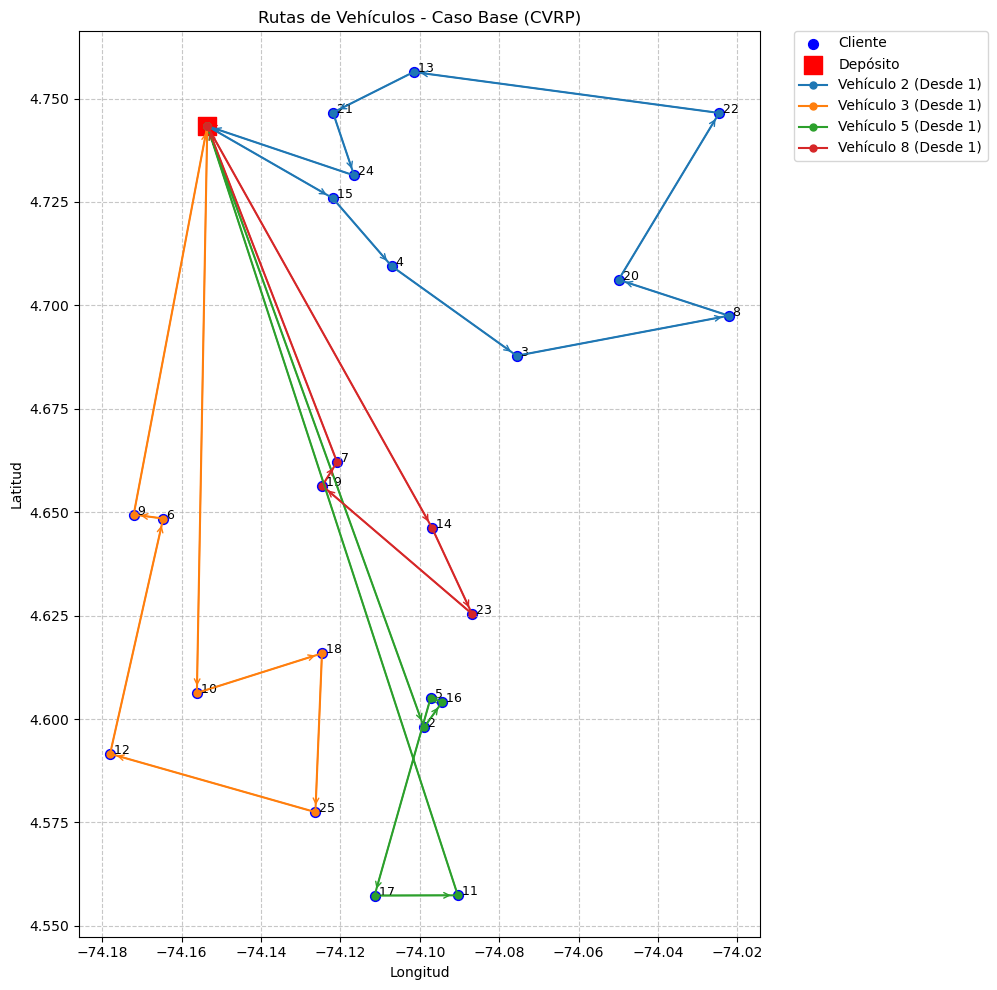

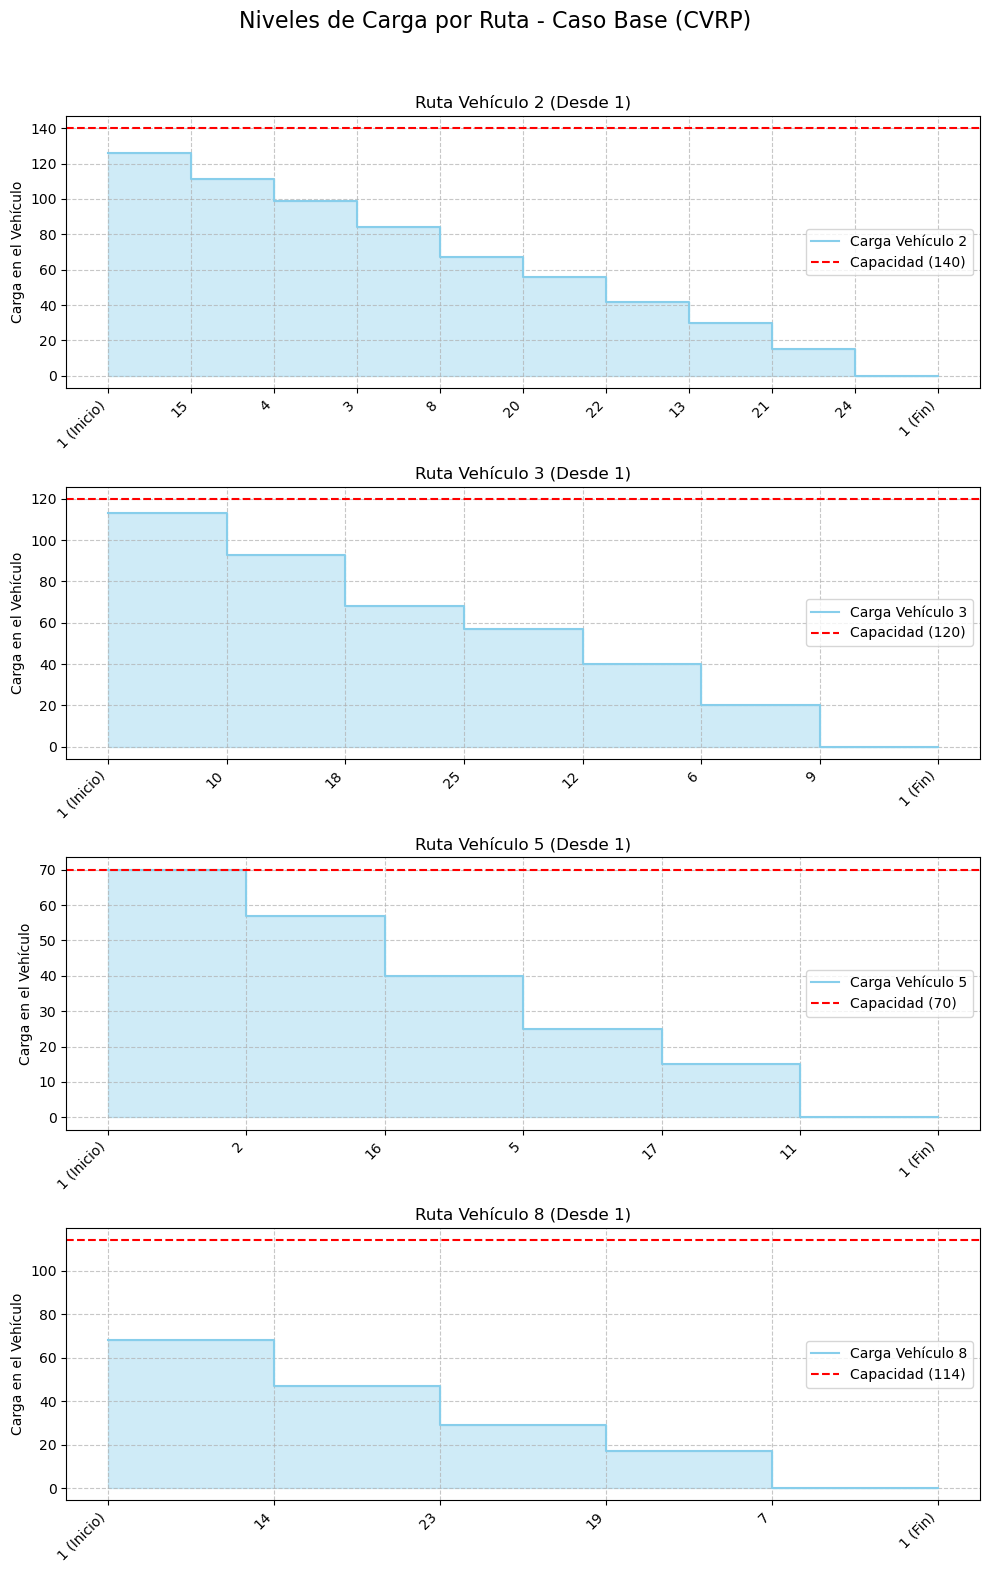

In [8]:
print("Visualización para el Caso Base (CVRP)")

if 'modelo' in locals() and 'resultados' in locals() and \
   (resultados.solver.status == SolverStatus.ok) and \
   (resultados.solver.termination_condition == TerminationCondition.optimal or \
    resultados.solver.termination_condition == TerminationCondition.feasible or \
    resultados.solver.termination_condition == TerminationCondition.maxTimeLimit):
    nombre_param_capacidad_caso_base = "capacidad"
    if not hasattr(modelo, nombre_param_capacidad_caso_base):
        if hasattr(modelo, "capacidad_vehiculo"):
             nombre_param_capacidad_caso_base = "capacidad_vehiculo"
        else:
            print(f"ADVERTENCIA: No se encontró el parámetro de capacidad '{nombre_param_capacidad_caso_base}' o 'capacidad_vehiculo' en el modelo base.")


    rutas_info_caso_base = extraer_datos_rutas(
        pyomo_model=modelo,
        df_all_locations=df_ubicaciones_para_matriz,
        df_clients_data=df_clientes,
        df_vehicles_data=df_vehiculos,
        param_name_vehicle_capacity=nombre_param_capacidad_caso_base,
        single_depot_id=deposito_principal_id
    )

    if rutas_info_caso_base:
        graficar_rutas(rutas_info_caso_base, df_ubicaciones_para_matriz, titulo="Rutas de Vehículos - Caso Base (CVRP)")
        graficar_niveles_carga(rutas_info_caso_base, titulo="Niveles de Carga por Ruta - Caso Base (CVRP)")
    else:
        print("No se extrajeron rutas válidas para visualizar en el Caso Base.")

else:
    print("No se encontró una solución válida para el Caso Base o las variables del modelo no están definidas.")

## Visualizacion caso 2

### Verificacion Caso 2

In [9]:
import pandas as pd
from pyomo.environ import value
import os

VELOCIDAD_PROMEDIO_KMH = 30
COSTO_COMBUSTIBLE_POR_KM = 1500

HEADERS_VERIFICACION = [
    "VehicleId", "DepotId", "InitialLoad", "RouteSequence", "ClientsServed",
    "DemandsSatisfied", "TotalDistance", "TotalTime", "FuelCost"
]

datos_verificacion_caso2 = []

if (resultados_c2.solver.status == SolverStatus.ok) and \
   (resultados_c2.solver.termination_condition == TerminationCondition.optimal or
    resultados_c2.solver.termination_condition == TerminationCondition.feasible or
    resultados_c2.solver.termination_condition == TerminationCondition.maxTimeLimit):

    print("Generando archivo de verificación para Caso 2...")

    for k_vehiculo_id in modelo_c2.V_set:
        origen_dep_id = None
        for d_dep_id_loop in modelo_c2.D_set:
            if value(modelo_c2.y_dk[d_dep_id_loop, k_vehiculo_id]) > 0.5:
                origen_dep_id = d_dep_id_loop
                break

        if not origen_dep_id:
            continue

        ruta_nodos_ids = [str(origen_dep_id)]
        clientes_en_ruta_ids = []
        demandas_satisfechas_lista = []

        nodo_actual_id = origen_dep_id
        distancia_total_ruta = 0.0
        tiempo_total_ruta_minutos = 0.0

        for _ in range(len(modelo_c2.N_set) + 1):
            siguiente_nodo_encontrado = False
            for j_nodo_id in modelo_c2.N_set:
                if j_nodo_id != nodo_actual_id and value(modelo_c2.x[nodo_actual_id, j_nodo_id, k_vehiculo_id]) > 0.5:
                    dist_segmento = value(modelo_c2.dist[nodo_actual_id, j_nodo_id])
                    distancia_total_ruta += dist_segmento

                    if VELOCIDAD_PROMEDIO_KMH > 0:
                        tiempo_segmento_horas = dist_segmento / VELOCIDAD_PROMEDIO_KMH
                        tiempo_segmento_minutos = tiempo_segmento_horas * 60
                    else:
                        tiempo_segmento_minutos = 0
                    tiempo_total_ruta_minutos += tiempo_segmento_minutos

                    ruta_nodos_ids.append(str(j_nodo_id))

                    if j_nodo_id in modelo_c2.C_set:
                        clientes_en_ruta_ids.append(j_nodo_id)
                        demandas_satisfechas_lista.append(str(int(value(modelo_c2.demanda[j_nodo_id]))))

                    nodo_actual_id = j_nodo_id
                    siguiente_nodo_encontrado = True
                    break

            if not siguiente_nodo_encontrado:
                break

            if nodo_actual_id == origen_dep_id and len(ruta_nodos_ids) > 1:
                break

        if len(ruta_nodos_ids) == 1 and ruta_nodos_ids[0] == str(origen_dep_id):
             continue

        vehicle_id_str = str(k_vehiculo_id)
        depot_id_str = str(origen_dep_id)

        initial_load_val = sum(value(modelo_c2.demanda[cliente_id]) for cliente_id in clientes_en_ruta_ids)

        route_sequence_str = " - ".join(ruta_nodos_ids)
        clients_served_count = len(clientes_en_ruta_ids)
        demands_satisfied_str = "-".join(demandas_satisfechas_lista) if demandas_satisfechas_lista else ""

        total_distance_str = f"{distancia_total_ruta:.1f}"
        total_time_str = f"{tiempo_total_ruta_minutos:.1f}"

        fuel_cost_val = distancia_total_ruta * COSTO_COMBUSTIBLE_POR_KM
        fuel_cost_str = str(int(round(fuel_cost_val)))

        datos_verificacion_caso2.append({
            "VehicleId": vehicle_id_str,
            "DepotId": depot_id_str,
            "InitialLoad": int(round(initial_load_val)),
            "RouteSequence": route_sequence_str,
            "ClientsServed": clients_served_count,
            "DemandsSatisfied": demands_satisfied_str,
            "TotalDistance": total_distance_str,
            "TotalTime": total_time_str,
            "FuelCost": fuel_cost_str
        })

    if datos_verificacion_caso2:
        df_verificacion = pd.DataFrame(datos_verificacion_caso2, columns=HEADERS_VERIFICACION)
        ruta_archivo_verificacion_c2 = os.path.join(directorio_salida_caso2, "verificacion_caso2.csv")
        df_verificacion.to_csv(ruta_archivo_verificacion_c2, index=False, sep=',')
        print(f"Archivo de verificación 'verificacion_caso2.csv' generado exitosamente en '{directorio_salida_caso2}'.")
    else:
        print("No se generaron rutas válidas para incluir en el archivo de verificación del Caso 2.")

else:
    print("No se encontró solución para el Caso 2, no se generará archivo de verificación.")

Generando archivo de verificación para Caso 2...
Archivo de verificación 'verificacion_caso2.csv' generado exitosamente en 'Proyecto_Caso2_Resultados'.


### Graficas caso 2

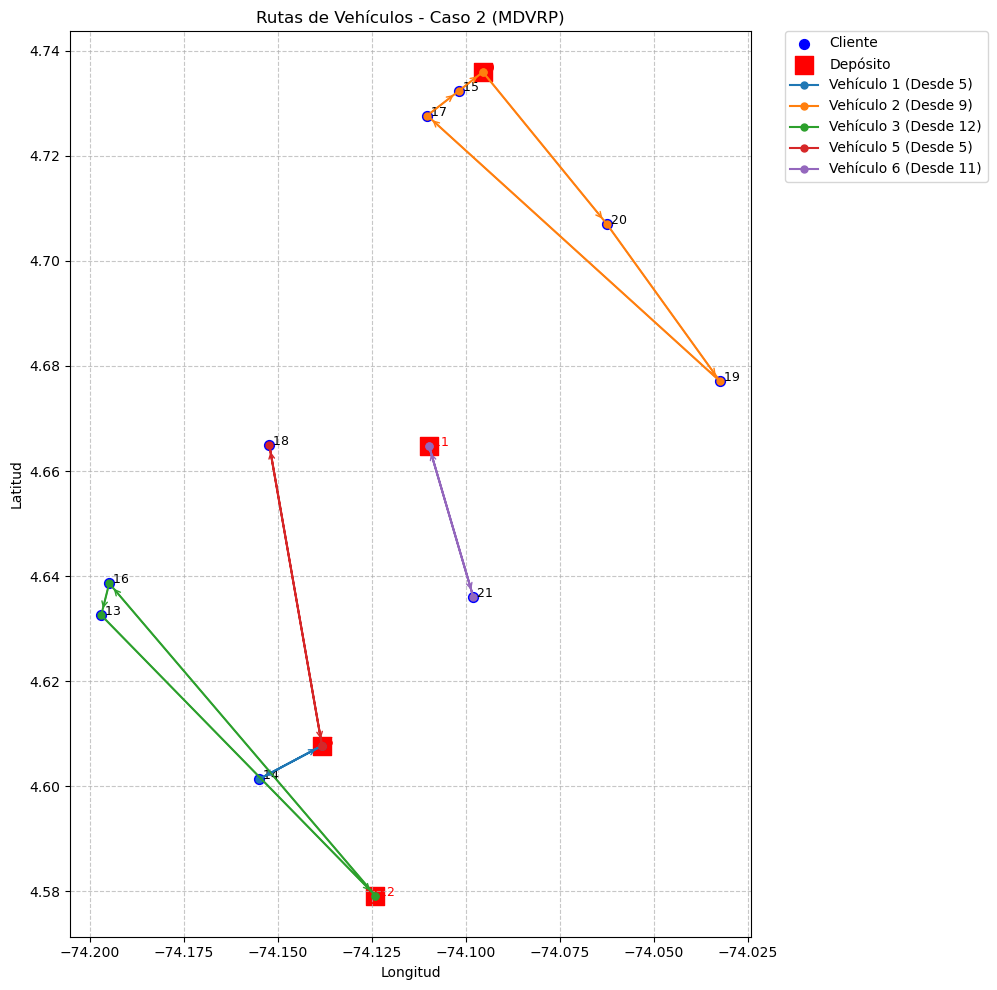

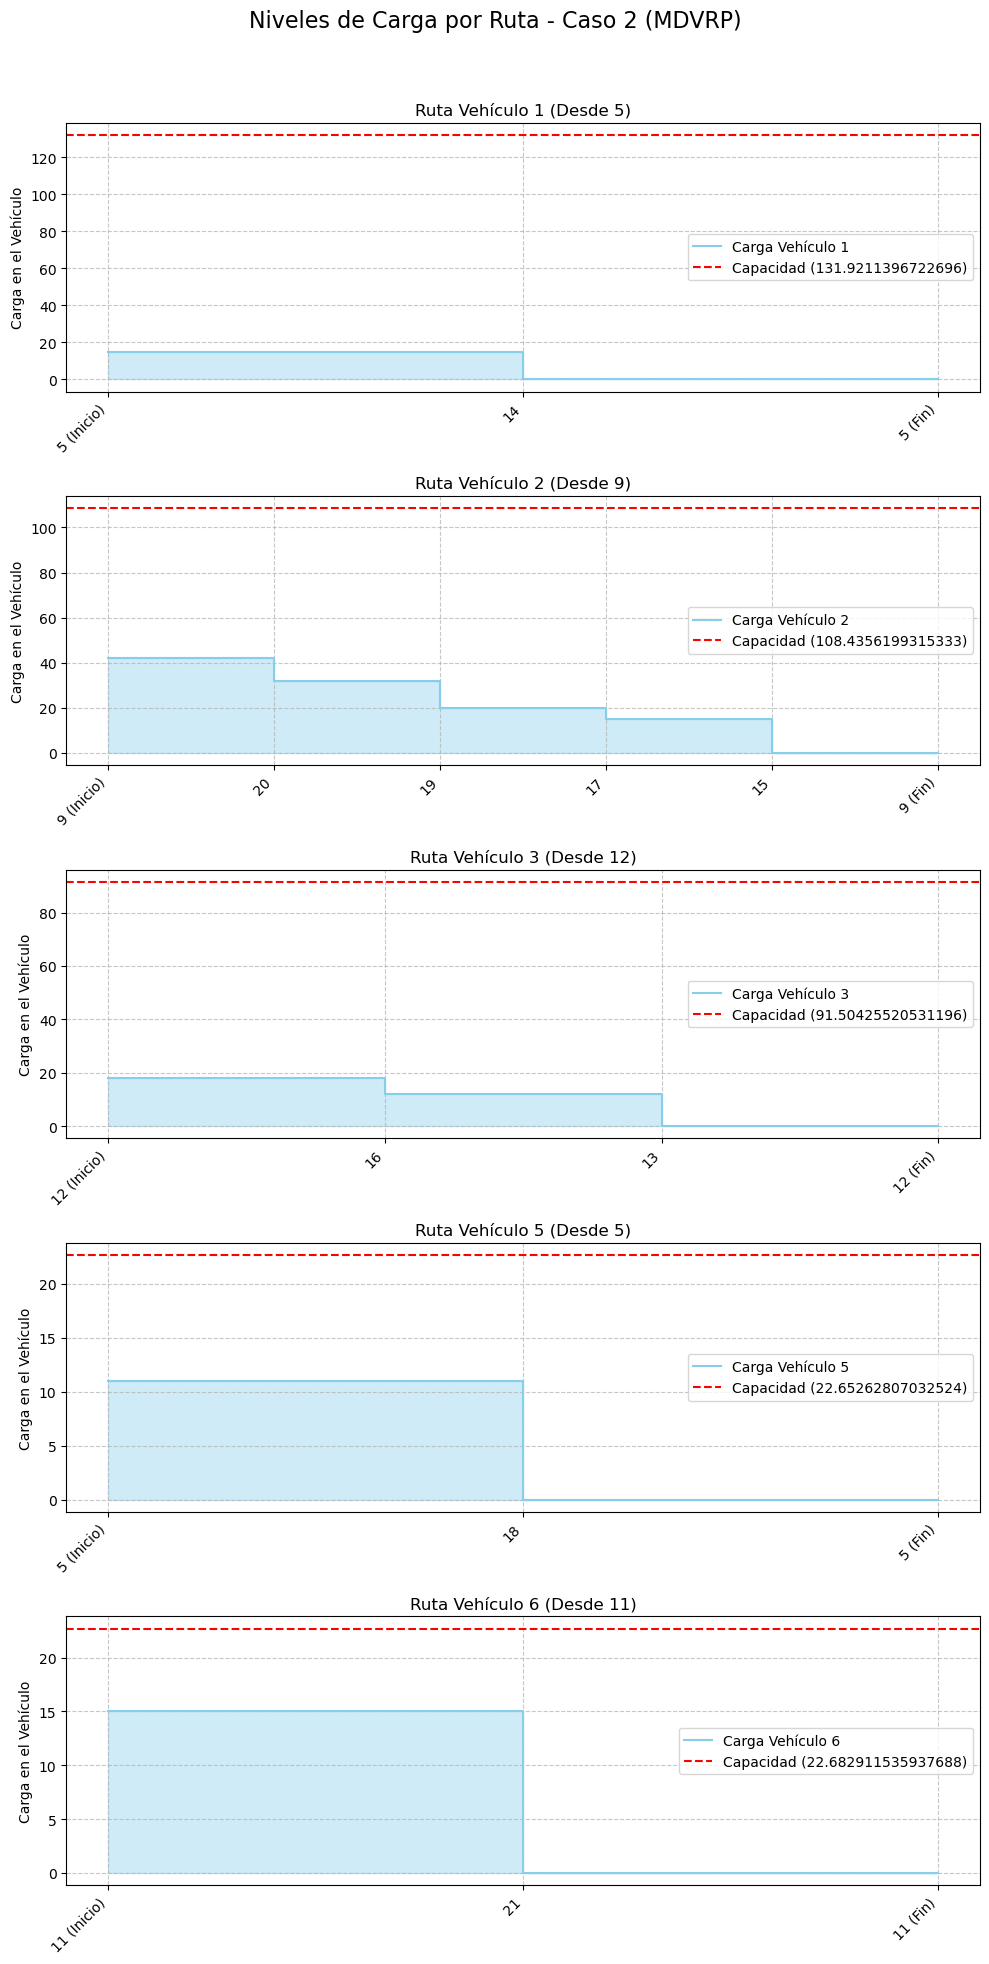

In [10]:

if 'modelo_c2' in locals() and \
   'resultados_c2' in locals() and \
   ('solution_is_truly_usable_in_model' in locals() and solution_is_truly_usable_in_model):

    nombre_param_capacidad_caso2 = "capacidad_vehiculo"

    rutas_info_caso2 = extraer_datos_rutas(
        pyomo_model=modelo_c2,
        df_all_locations=df_ubicaciones_consolidadas_c2,
        df_clients_data=df_clientes_c2,
        df_vehicles_data=df_vehiculos_c2,
        param_name_vehicle_capacity=nombre_param_capacidad_caso2,
        single_depot_id=None
    )

    if rutas_info_caso2:
        graficar_rutas(rutas_info_caso2,
                       df_ubicaciones_consolidadas_c2,
                       titulo="Rutas de Vehículos - Caso 2 (MDVRP)")

        graficar_niveles_carga(rutas_info_caso2,
                               titulo="Niveles de Carga por Ruta - Caso 2 (MDVRP)")
    else:
        print("No se extrajeron rutas válidas para visualizar en el Caso 2.")
else:
    print("No se encontró una solución válida/utilizable para el Caso 2 o las variables del modelo no están definidas/cargadas.")

## Caso 3: Escenario Realista

Este escenario busca acercar el modelo a una situación empresarial más realista. Se desarrollan los siguientes elementos:

- Adaptación del modelo para atender entre **50 y 100 clientes**.
- Inclusión de una **flota heterogénea**, compuesta por vehículos con distintas capacidades, autonomías y costos.
- Modelación de **restricciones urbanas avanzadas**, como zonas con penalización, ventanas de tiempo y límites de acceso.
- Análisis exhaustivo con **enfoque empresarial** incluyendo métricas de uso de recursos, costos totales y eficiencia logística.

In [14]:

clientes_caso3 = pd.read_csv(r'D:\Biblioteca\Escritorio\ok\caso3\clients.csv')
vehiculos_caso3 = pd.read_csv(r'D:\Biblioteca\Escritorio\ok\caso3\vehicles.csv')
depositos_caso3 = pd.read_csv(r'D:\Biblioteca\Escritorio\ok\caso3\depots.csv')
vehiculos_caso3.head()

,VehicleID,Capacity,Range
0,1,132,146
1,2,136,196
2,3,115,143
3,4,158,174
4,5,109,167


In [15]:
# Construcción del modelo Pyomo con restricciones adicionales
model = ConcreteModel()

# Sets
model.I = Set(initialize=depositos_caso3['DepotID'].tolist())
model.J = Set(initialize=clientes_caso3['ClientID'].tolist())
model.K = Set(initialize=vehiculos_caso3['VehicleID'].tolist())

# Parameters
model.Q = Param(model.K, initialize=vehiculos_caso3.set_index('VehicleID')['Capacity'].to_dict())
model.R = Param(model.K, initialize=vehiculos_caso3.set_index('VehicleID')['Range'].to_dict())



## Análisis del Caso 3


### ¿Cuáles son los parámetros iniciales que más afectan la logística urbana?
- **Capacidad de los vehículos**: define cuántos clientes puede atender un vehículo antes de regresar o recargar. Una baja capacidad genera más recorridos y mayor uso de flota.
- **Autonomía de los vehículos**: restringe la distancia máxima recorrida. Si es limitada, impide optimizar rutas largas o atender zonas alejadas.
- **Ubicación de los depósitos**: influye directamente en la distancia total recorrida. Depósitos mal ubicados generan rutas ineficientes.
- **Demanda de los clientes**: cuando la demanda total se acerca al límite de la flota, se incrementa la complejidad logística.
- **Costo fijo de operación por vehículo**: determina la presión por minimizar el número de vehículos usados y agrupar más clientes por unidad.
### ¿Dónde se presentan los mayores cuellos de botella?
- **Clientes aislados**: generan mayor consumo de autonomía y costos logísticos, especialmente si no están cerca de un depósito.
- **Asignación de vehículos heterogéneos mal balanceada**: si no se elige bien qué vehículo se usa, pueden desperdiciarse unidades con más capacidad/autonomía.
- **Limitaciones por autonomía**: algunos vehículos no pueden completar rutas eficientes por restricciones de rango, obligando a usar más vehículos o hacer viajes cortos.
- **Uso parcial de la flota**: si el modelo favorece pocos vehículos por costos fijos, puede sobrecargarlos y forzar rutas subóptimas o no factibles.
### ¿Qué mejoras recomendaría a LogistiCo?
- **Reubicar o agregar depósitos**: análisis de cobertura puede sugerir crear depósitos satélite más cercanos a grupos de alta demanda.
- **Optimizar composición de la flota**: incluir más vehículos medianos o eléctricos con buena autonomía/capacidad según los patrones observados.
- **Aplicar rutas con ventanas de tiempo y penalizaciones urbanas**: para reflejar mejor restricciones reales (zonas pico, tráfico, peajes).
- **Visualización de rutas y monitoreo**: implementar dashboards con rutas sugeridas, uso de flota y métricas operativas clave para toma de decisiones.

In [26]:
import time
import tracemalloc
import numpy as np
import pandas as pd
from pyomo.environ import SolverFactory, value


def extract_routes_from_model(model, depot_id, loc2idx):
    routes = []
    for k in model.V_set:
        current = depot_id
        visited = {current}
        route = []
        while True:
            nxt = None
            for j in model.N_set:
                if j != current and value(model.x[current,j,k]) > 0.5 and j not in visited:
                    nxt = j
                    break
            if nxt is None:
                break
            route.append(loc2idx[nxt])
            visited.add(nxt)
            current = nxt
        routes.append(route)
    return routes

def compute_cvrp_metrics(solution, dist_mat, demands, capacities, ranges,
                         depot_idx=0, penalty_capacity=1000, penalty_range=1000):
    total_dist = 0
    total_pen  = 0
    loads      = []
    for v_idx, route in enumerate(solution):
        if not route:
            loads.append(0)
            continue
        d = dist_mat[depot_idx, route[0]]
        for i in range(len(route)-1):
            d += dist_mat[route[i], route[i+1]]
        d += dist_mat[route[-1], depot_idx]
        total_dist += d
        load = sum(demands[i] for i in route)
        loads.append(load)
        cap_ex = max(0, load - capacities[v_idx])
        rng_ex = max(0, d - ranges[v_idx])
        total_pen += cap_ex*penalty_capacity + rng_ex*penalty_range
    fitness = total_dist + total_pen
    return {
        'objective':    fitness,
        'distance':     total_dist,
        'num_vehicles': sum(1 for l in loads if l>0),
        'std_load':     np.std(loads)
    }

def measure_performance(func, *args, **kwargs):
    tracemalloc.start()
    t0 = time.time()
    out = func(*args, **kwargs)
    t1 = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return out, (t1-t0), (peak/1024**2)

def measure_pyomo_case(model,
                       df_ubic, df_cli, df_dep, df_veh, df_dist):
    loc_ids = df_ubic['LocationID'].tolist()
    loc2idx = {loc:i for i,loc in enumerate(loc_ids)}
    dist_mat = df_dist.values
    dem_map  = pd.Series(df_cli['Demand'].values,
                        index=df_cli['LocationID']).to_dict()
    demands  = [dem_map.get(loc,0) for loc in loc_ids]
    capacities = df_veh['Capacity'].tolist()
    ranges     = df_veh['Range'].tolist()
    depot_id   = df_dep['LocationID'].iloc[0]
    depot_idx  = loc2idx[depot_id]
    def solve_and_extract():
        solver = SolverFactory('glpk')
        solver.options['tmlim'] = 300
        solver.solve(model, tee=False)
        obj    = value(model.obj)
        routes = extract_routes_from_model(model, depot_id, loc2idx)
        return obj, routes
    (obj_val, routes), t_s, mem_mb = measure_performance(solve_and_extract)
    m = compute_cvrp_metrics(routes, dist_mat, demands, capacities, ranges, depot_idx)
    m.update({'solve_time_s': t_s, 'mem_peak_mb': mem_mb})
    return m


metrics_base = measure_pyomo_case(
    modelo,
    df_ubicaciones_para_matriz,    
    df_clientes,                   
    df_depositos,                 
    df_vehiculos,                  
    df_matriz_distancias  
)


for name, m in [('Base', metrics_base)]:
    print(f"=== Pyomo {name} ===")
    print(f"Objetivo (fitness):      {m['objective']:.2f}")
    print(f"Distancia total (km):    {m['distance']:.2f}")
    print(f"Vehículos usados:        {m['num_vehicles']}")
    print(f"Std. dev. de carga:      {m['std_load']:.2f}")
    print(f"Tiempo de ejecución (s): {m['solve_time_s']:.2f}")
    print(f"Memoria pico (MB):       {m['mem_peak_mb']:.2f}\n")


=== Pyomo Base ===
Objetivo (fitness):      168.11
Distancia total (km):    168.11
Vehículos usados:        4
Std. dev. de carga:      50.50
Tiempo de ejecución (s): 301.77
Memoria pico (MB):       4.19



In [27]:
import time, tracemalloc
import numpy as np
from pyomo.environ import SolverFactory, value

metrics_base = measure_pyomo_case(
    modelo, 
    df_ubicaciones_para_matriz, 
    df_clientes, 
    df_depositos, 
    df_vehiculos, 
    df_matriz_distancias
)


def solve_case2_and_extract_loads():
    solver = SolverFactory('glpk')
    solver.options['tmlim'] = 300
    solver.solve(modelo_c2, tee=False)
    obj2 = value(modelo_c2.obj)

    loads2 = [value(modelo_c2.carga_vehiculo_k_expr[k]) for k in modelo_c2.V_set]
    return obj2, loads2


tracemalloc.start()
t0 = time.time()
obj2, loads2 = solve_case2_and_extract_loads()
t1 = time.time()
_, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

time2 = t1 - t0
mem2  = peak / 1024**2

metrics_2 = {
    'objective':     obj2,           
    'distance':      obj2,
    'num_vehicles':  sum(1 for l in loads2 if l > 0),
    'std_load':      np.std(loads2),
    'solve_time_s':  time2,
    'mem_peak_mb':   mem2
}

print("=== Pyomo Base ===")
print(f"Objetivo:      {metrics_base['objective']:.2f}")
print(f"Distancia:     {metrics_base['distance']:.2f}")
print(f"Vehículos:     {metrics_base['num_vehicles']}")
print(f"Std. carga:    {metrics_base['std_load']:.2f}")
print(f"Tiempo (s):    {metrics_base['solve_time_s']:.2f}")
print(f"Mem (MB):      {metrics_base['mem_peak_mb']:.2f}\n")

print("=== Pyomo Caso 2 ===")
print(f"Objetivo:      {metrics_2['objective']:.2f}")
print(f"Distancia:     {metrics_2['distance']:.2f}")
print(f"Vehículos:     {metrics_2['num_vehicles']}")
print(f"Std. carga:    {metrics_2['std_load']:.2f}")
print(f"Tiempo (s):    {metrics_2['solve_time_s']:.2f}")
print(f"Mem (MB):      {metrics_2['mem_peak_mb']:.2f}")


=== Pyomo Base ===
Objetivo:      168.11
Distancia:     168.11
Vehículos:     4
Std. carga:    50.50
Tiempo (s):    302.05
Mem (MB):      4.20

=== Pyomo Caso 2 ===
Objetivo:      66.57
Distancia:     66.57
Vehículos:     5
Std. carga:    12.64
Tiempo (s):    300.93
Mem (MB):      2.93


Prueba Caso 3

In [29]:

import pandas as pd
import numpy as np

clients_df = pd.read_csv(r'D:\Biblioteca\Escritorio\ok\caso3\clients.csv')
vehicles_df = pd.read_csv(r'D:\Biblioteca\Escritorio\ok\caso3\vehicles.csv')
depots_df = pd.read_csv(r'D:\Biblioteca\Escritorio\ok\caso3\depots.csv')

subset_clients = clients_df.sample(n=min(100, max(50, len(clients_df))), random_state=42).reset_index(drop=True)

def aplicar_restricciones_urbanas(df):
    df['zona_restringida'] = np.random.choice([True, False], size=len(df), p=[0.3, 0.7])
    df['horario_restriccion'] = df['zona_restringida'].apply(lambda x: '7-9am / 5-7pm' if x else 'Ninguna')
    return df

subset_clients = aplicar_restricciones_urbanas(subset_clients)

flota_heterogenea = vehicles_df.copy()
flota_heterogenea['costo_km'] = np.where(flota_heterogenea['Capacity'] > 1000, 3.5, 2.0)

cobertura_total = len(subset_clients)
zonas_restringidas = subset_clients['zona_restringida'].sum()
porcentaje_restringido = zonas_restringidas / cobertura_total * 100

costos_estimados = cobertura_total * flota_heterogenea['costo_km'].mean() * 10 

print("🔍 Análisis Escenario Realista:")
print(f"Total de clientes seleccionados: {cobertura_total}")
print(f"Clientes en zonas restringidas: {zonas_restringidas} ({porcentaje_restringido:.2f}%)")
print(f"Costo estimado total: ${costos_estimados:,.2f}")
print("Flota heterogénea usada, ", flota_heterogenea[['VehicleID', 'Capacity', 'costo_km']])
print("Ejemplo de clientes con restricciones", subset_clients[subset_clients['zona_restringida']].head())


🔍 Análisis Escenario Realista:
Total de clientes seleccionados: 90
Clientes en zonas restringidas: 33 (36.67%)
Costo estimado total: $1,800.00
Flota heterogénea usada,      VehicleID  Capacity  costo_km
0           1       132       2.0
1           2       136       2.0
2           3       115       2.0
3           4       158       2.0
4           5       109       2.0
5           6       109       2.0
6           7       126       2.0
7           8        79       2.0
8           9        96       2.0
9          10        99       2.0
10         11       125       2.0
11         12        98       2.0
12         13        86       2.0
13         14        74       2.0
14         15        85       2.0
15         16        22       2.0
16         17        25       2.0
17         18        30       2.0
18         19        27       2.0
19         20        19       2.0
20         21        29       2.0
21         22        25       2.0
22         23        18       2.0
23         24  